# Per-Decision variance comparison
We want to inspect the differences in variance (by comparing the performances) of vanilla-POIS versus Per-Decision-POIS (PD-POIS).
We start by loading the necessary data from sacred file storage.

In [1]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

First we need to load all the runs from the sacred dataset.

In [2]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))

Loaded runs: 572
Loaded final runs: 704


In [15]:
pdisnn_runs_local = load_runs('../sacred_pdisnn/')
print("Loaded pdisnn runs:", len(pdisnn_runs_local.keys()))

Loaded pdisnn runs: 453


In [16]:
# Merge the runs
total_runs = {}
for key, value in final_runs.items():
    total_runs[str(key) + '-final'] = value
for key, value in pdisnn_runs_local.items():
    total_runs[str(key) + '-local'] = value

We also create a base query which will be used throughout this notebook:

In [17]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': False,
    'config.gamma': 1.0,
    'config.clipping': False,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

These properties are common to each experiment here.

## CartPole
We start by inspecting the CartPole environment, using 100 episodes for each iteration as used in the paper. Since Per-Decision POIS seemed to get stuck in some situations, we also tried to enforce exploration through an entropy bonus. This entropy bonus is given only in the first 100 iterations (over a total of 500 iterations), and is scaled by a factor of 10 (which was found after some experiments).

----------------------------------------
Method: is  - Delta: 0.4
Experiments: 20
Seeds: 545, 245, 307, 746, 8, 42, 481, 236, 247, 15, 153, 100, 689, 178, 947, 315, 712, 950, 662, 963
----------------------------------------
Method: pdis  - Delta: 0.99
Experiments: 45
Seeds: 245, 236, 662, 236, 15, 178, 545, 15, 947, 689, 153, 545, 904, 712, 481, 10, 963, 315, 42, 570, 247, 950, 481, 100, 307, 963, 153, 947, 247, 42, 746, 662, 689, 315, 8, 160, 245, 109, 746, 178, 100, 712, 950, 307, 8
----------------------------------------
Method: is  - Delta: 0.4
Experiments: 20
Seeds: 245, 746, 712, 545, 178, 689, 963, 247, 481, 236, 100, 947, 315, 153, 15, 950, 307, 662, 42, 8
----------------------------------------
Method: pdis  - Delta: 0.99
Experiments: 39
Seeds: 100, 178, 315, 245, 712, 315, 689, 307, 947, 15, 963, 712, 662, 746, 8, 481, 950, 100, 42, 247, 15, 245, 236, 947, 42, 153, 746, 689, 8, 247, 545, 178, 236, 481, 950, 153, 307, 545, 963
----------------------------------------
Method

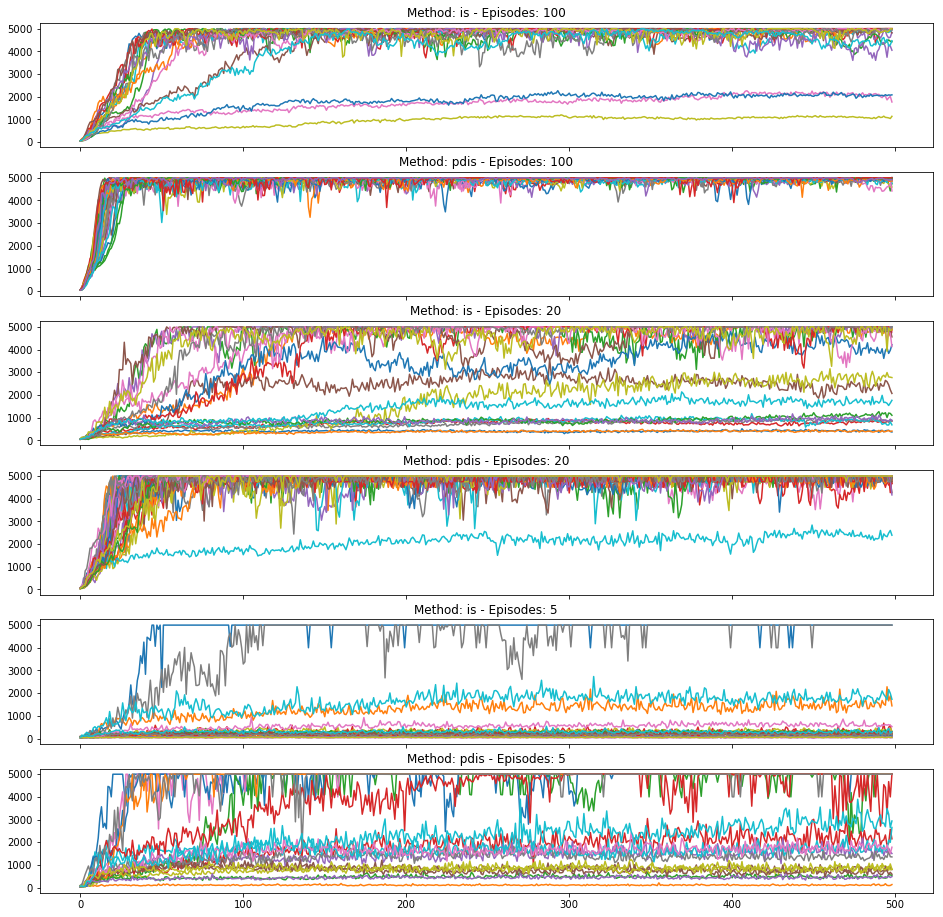

In [13]:
fig, axis = plt.subplots(nrows=6, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta, episodes) in enumerate([('is', 'max-d2', 0.4, 100),
                                                      ('pdis', 'pdis-max-d2', 0.99, 100),
                                                      ('is', 'max-d2', 0.4, 20),
                                                      ('pdis', 'pdis-max-d2', 0.99, 20),
                                                      ('is', 'max-d2', 0.4, 5),
                                                      ('pdis', 'pdis-max-d2', 0.99, 5),
                                                     ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.cartpole',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': episodes,
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i], legend=False)
    axis[i].set_title("Method: " + method + " - Episodes: " + str(episodes))
plt.show();

----------------------------------------
Method: is  - Delta: 0.9
Experiments: 20
Seeds: 662, 950, 963, 236, 8, 42, 689, 178, 153, 247, 100, 947, 746, 15, 315, 307, 245, 712, 545, 481
----------------------------------------
Method: pdis  - Delta: 0.9999
Experiments: 45
Seeds: 481, 236, 247, 245, 904, 109, 570, 178, 307, 746, 42, 963, 689, 712, 100, 153, 662, 947, 15, 10, 8, 315, 545, 160, 950, 545, 236, 662, 153, 746, 712, 950, 481, 307, 42, 15, 315, 245, 947, 963, 689, 178, 100, 247, 8
----------------------------------------
Method: is  - Delta: 0.9
Experiments: 20
Seeds: 481, 15, 153, 963, 315, 950, 42, 8, 100, 545, 236, 662, 307, 178, 712, 245, 247, 947, 746, 689
----------------------------------------
Method: pdis  - Delta: 0.9999
Experiments: 40
Seeds: 481, 42, 545, 15, 15, 315, 307, 481, 8, 662, 42, 689, 178, 712, 963, 245, 712, 947, 950, 247, 746, 689, 315, 247, 307, 963, 8, 178, 545, 245, 947, 950, 153, 153, 662, 100, 236, 236, 100, 746
--------------------------------------

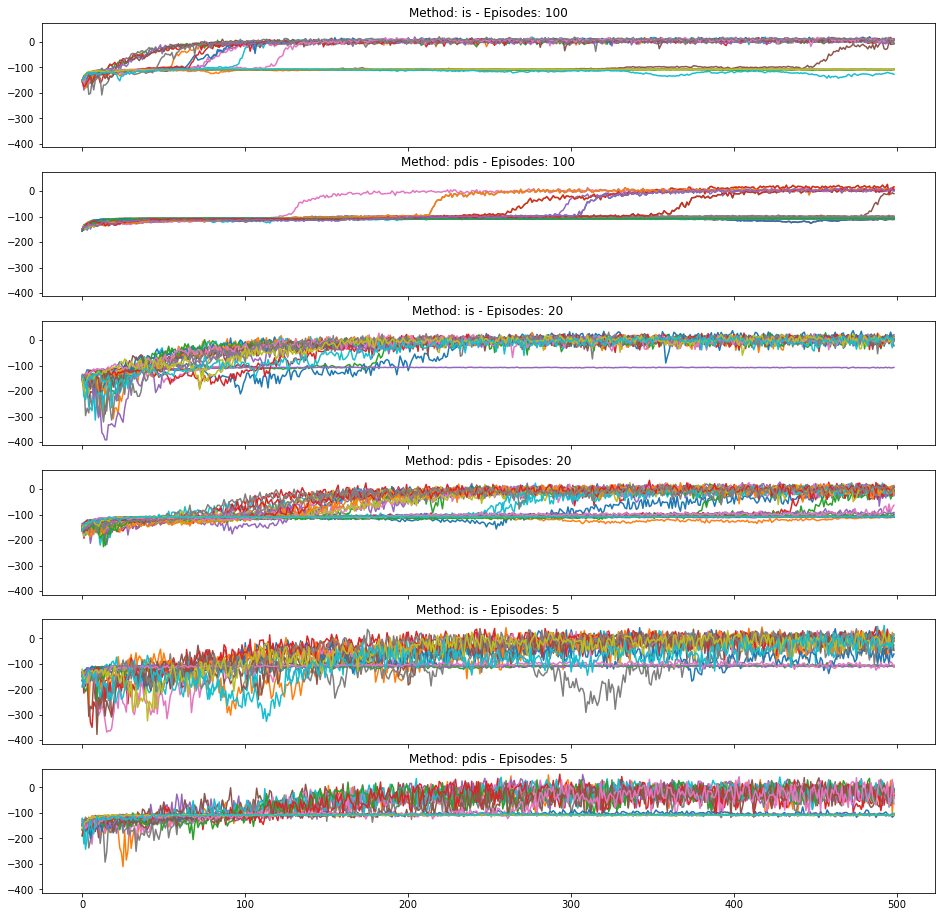

In [18]:
fig, axis = plt.subplots(nrows=6, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, delta, episodes) in enumerate([('is', 'max-d2', 0.9, 100),
                                                      ('pdis', 'pdis-max-d2', 0.9999, 100),
                                                      ('is', 'max-d2', 0.9, 20),
                                                      ('pdis', 'pdis-max-d2', 0.9999, 20),
                                                      ('is', 'max-d2', 0.9, 5),
                                                      ('pdis', 'pdis-max-d2', 0.9999, 5),
                                                     ]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': episodes,
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i], legend=False)
    axis[i].set_title("Method: " + method + " - Episodes: " + str(episodes))
plt.show();

## Importance weights and J variance estimation

std(IW) PDIS: 0.8774417592032966
std(IW) IS: 1.7034493859530122
var(J) PDIS: 3.4600752975947073
var(J) IS: 6.679162723303736


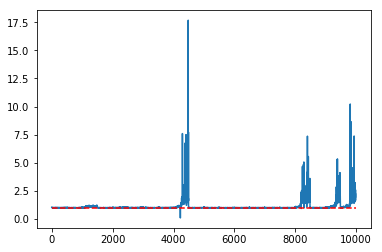

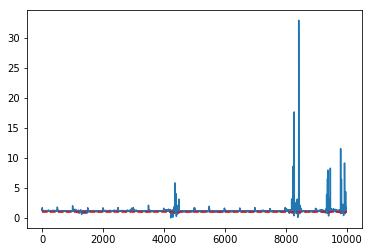

In [40]:
query = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'pdis',
        'config.delta': 0.9999,
        'config.bound': 'pdis-max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros',
        'config.experiment_name': 'pdis_variance_test_v2std'
}
filtered_runs = filter_runs({**base_query, **query}, total_runs)
stdIW, ISstdIW, Jvar, ISJvar = [], [], [], []
for run_key, run in filtered_runs.items():
    stdIW.extend(run['metrics']['StdIW_mean']['values'])
    ISstdIW.extend(run['metrics']['IS_StdIW']['values'])
    Jvar.extend(run['metrics']['J_sample_variance']['values'])
    ISJvar.extend(run['metrics']['IS_J_sample_variance']['values'])
    
print('std(IW) PDIS:', np.mean(stdIW))
print('std(IW) IS:', np.mean(ISstdIW))
print('var(J) PDIS:', np.mean(Jvar) / 1e6)
print('var(J) IS:', np.mean(ISJvar) / 1e6)

ratio_iw = np.array(ISstdIW) / np.array(stdIW)
ratio_J = np.array(ISJvar) / np.array(Jvar)
plt.plot(ratio_iw)
plt.plot([0, 10000], [1, 1], 'r--')
plt.show();
plt.plot(ratio_J)
plt.plot([0, 10000], [1, 1], 'r--')
plt.show();

## Inverted pendulum

In [ ]:
fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(16,8), sharex=True, sharey=True)
for i, (method, bound, delta) in enumerate([('is', 'max-d2', 0.9),
                                              ('pdis', 'pdis-max-d2', 0.9999)]):
    query = {
        'config.entropy': 'none',
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': method,
        'config.delta': delta,
        'config.bound': bound,
        'config.num_episodes': 20,
    }
    filtered_runs = filter_runs({**base_query, **query}, total_runs)
    print('----------------------------------------')
    print("Method:", method, " - Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpLenMean', axis[i])
    axis[i].set_title("Method: " + method + " - Delta: " + str(delta))
plt.show();

In [ ]:
query1 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros'
    }
query2 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'pdis',
        'config.delta': 0.9999,
        'config.bound': 'pdis-max-d2',
        'config.num_episodes': 100,
        'config.policy_init': 'zeros'
    }
filtered_runs1 = filter_runs({**base_query, **query1}, total_runs)
filtered_runs2 = filter_runs({**base_query, **query2}, total_runs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs1, 'EpRewMean', axis)
plot_mean_ci(filtered_runs2, 'EpRewMean', axis)
axis.set_ylim(-200, 50)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs1[key]['config']['seed'] for key in filtered_runs1.keys()])))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs1.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN1 std(IW):", np.mean(stdIWs))
print("RUN1 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs2.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN2 std(IW):", np.mean(stdIWs))
print("RUN2 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

In [ ]:
query1 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'is',
        'config.delta': 0.9,
        'config.bound': 'max-d2',
        'config.num_episodes': 20,
        'config.policy_init': 'zeros'
    }
query2 = {
        'config.env': 'rllab.inverted-pendulum',
        'config.iw_method': 'pdis',
        'config.delta': 0.9999,
        'config.bound': 'pdis-max-d2',
        'config.num_episodes': 20,
        'config.policy_init': 'zeros'
    }
filtered_runs1 = filter_runs({**base_query, **query1}, total_runs)
filtered_runs2 = filter_runs({**base_query, **query2}, total_runs)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
plot_mean_ci(filtered_runs1, 'EpRewMean', axis)
plot_mean_ci(filtered_runs2, 'EpRewMean', axis)
axis.set_ylim(-200, 50)
plt.show();
print("Seeds:", ", ".join(map(str, [filtered_runs1[key]['config']['seed'] for key in filtered_runs1.keys()])))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs1.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN1 std(IW):", np.mean(stdIWs))
print("RUN1 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

stdIWs = []
variances = []
Js = []
for run_key, run in filtered_runs2.items():
    stdIW = run['metrics']['StdIW']['values'][:20]
    variance = run['metrics']['J_sample_variance']['values'][:20]
    J = run['metrics']['ReturnMeanIW']['values'][:20]
    stdIWs.extend(stdIW)
    variances.extend(variance)
    Js.extend([np.std(J)])
print("RUN2 std(IW):", np.mean(stdIWs))
print("RUN2 var(J):", np.mean(variances))
print("RUN1 mean(J):", np.mean(Js))

In [ ]:
total_runs['99-local']['metrics'].keys()